In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as cr, confusion_matrix as cm, roc_auc_score
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import lightgbm as lgb







In [154]:
colors = ['skyblue', 'orange']  # class 0 = skyblue, class 1 = orange

# 1. Load dataset
df = pd.read_csv("../Fraud_dataset.csv")
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [155]:
counts = df['fraud_bool'].value_counts()
majority = counts.max()
minority = counts.min()

imbalance_ratio = majority / minority
print("Majority class:", majority)
print("Minority class:", minority)
print("Imbalance Ratio (IR):", imbalance_ratio)

total = len(df)
minority_pct = (minority / total) * 100
print("Minority class percentage:", minority_pct)

Majority class: 988971
Minority class: 11029
Imbalance Ratio (IR): 89.67005168192946
Minority class percentage: 1.1029


In [156]:
df = df.apply(
    lambda col: col.str.lower() if col.dtype == "object" else col
)


In [157]:
# 2. Separate features and target
X = df.drop(columns=["fraud_bool"])
y = df["fraud_bool"]
print(X.head())
print(y.head())

   income  name_email_similarity  prev_address_months_count  \
0     0.3               0.986506                         -1   
1     0.8               0.617426                         -1   
2     0.8               0.996707                          9   
3     0.6               0.475100                         11   
4     0.9               0.842307                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            25            40            0.006735   
1                            89            20            0.010095   
2                            14            40            0.012316   
3                            14            30            0.006991   
4                            29            40            5.742626   

   intended_balcon_amount payment_type  zip_count_4w   velocity_6h  ...  \
0              102.453711           aa          1059  13096.035018  ...   
1               -0.849551           ad          1658   9

In [158]:
# 3. Identify categorical columns
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Convert categorical columns to numeric category codes for SMOTENC
X_encoded = X.copy()
for col in categorical_cols:
    X_encoded[col] = X_encoded[col].astype("category").cat.codes

X_encoded.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0.3,0.986506,-1,25,40,0.006735,102.453711,0,1059,13096.035018,...,0,1500.0,0,0,16.224843,0,1,1,0,0
1,0.8,0.617426,-1,89,20,0.010095,-0.849551,3,1658,9223.283431,...,0,1500.0,0,0,3.363854,2,1,1,0,0
2,0.8,0.996707,9,14,40,0.012316,-1.490386,1,1095,4471.472149,...,0,200.0,0,0,22.730559,3,0,1,0,0
3,0.6,0.475100,11,14,30,0.006991,-1.863101,1,3483,14431.993621,...,0,200.0,0,0,15.215816,0,1,1,0,0
4,0.9,0.842307,-1,29,40,5.742626,47.152498,0,2339,7601.511579,...,0,200.0,0,0,3.743048,2,0,1,0,0


In [159]:
# 4. Train-test split BEFORE any resampling
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train[0:3], X_test[0:3], y_train[0:3], y_test[0:3])

        income  name_email_similarity  prev_address_months_count  \
39111      0.7               0.229712                         -1   
822700     0.2               0.928428                        199   
914415     0.1               0.658630                         95   

        current_address_months_count  customer_age  days_since_request  \
39111                             63            50            0.024720   
822700                            24            70            0.014153   
914415                             2            40            0.045801   

        intended_balcon_amount  payment_type  zip_count_4w   velocity_6h  ...  \
39111                50.674001             0          1305  12764.326278  ...   
822700               15.631407             0           833   9717.635327  ...   
914415               -1.410133             1           237   2201.833206  ...   

        has_other_cards  proposed_credit_limit  foreign_request  source  \
39111                 1       

In [160]:
# 5. Get categorical column indices for SMOTENC
categorical_idx = [X_train.columns.get_loc(col) for col in categorical_cols]

# -------------------------------
# 6. TRUE HYBRID SAMPLING
# -------------------------------
# Partial undersampling of majority class
undersampler = RandomUnderSampler(
    sampling_strategy=0.15,   # majority becomes 2× minority
    random_state=42
)

# SMOTENC oversampling for categorical + numeric mixed data
smote_nc = SMOTENC(
    categorical_features=categorical_idx,
    random_state=42,
    sampling_strategy="auto"
)

# Pipeline applies UnderSampling → OverSampling
pipeline = Pipeline([
    ("under", undersampler),
    ("over", smote_nc)
])

X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)
print(X_resampled[0:3], y_resampled[0:3])

   income  name_email_similarity  prev_address_months_count  \
0     0.1               0.019742                         59   
1     0.9               0.185549                         -1   
2     0.2               0.802497                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            67            20            1.545615   
1                           135            30            0.012995   
2                           362            20            0.013370   

   intended_balcon_amount  payment_type  zip_count_4w  velocity_6h  ...  \
0                6.892693             0          1625  6060.121833  ...   
1               -0.620119             1           887  4896.123247  ...   
2               97.709532             0           641  5063.524588  ...   

   has_other_cards  proposed_credit_limit  foreign_request  source  \
0                0                  200.0                0       0   
1                0           

In [161]:
# -------------------------------
# 7. BEFORE vs AFTER class counts
# -------------------------------
before_counts = y_train.value_counts()
after_counts = y_resampled.value_counts()

print("Before Hybrid Sampling:\n", before_counts)
print("\nAfter Hybrid Sampling:\n", after_counts)

# -------------------------------
# 8. CALCULATE sampling amounts
# -------------------------------
before_majority = before_counts.max()
before_minority = before_counts.min()

after_majority = after_counts.max()
after_minority = after_counts.min()

# How much undersampling?
undersampled_amount = before_majority - after_majority
undersampled_percent = (undersampled_amount / before_majority) * 100

# How much oversampling?
oversampled_amount = after_minority - before_minority
oversampled_percent = (oversampled_amount / before_minority) * 100

print("\n===== SAMPLING SUMMARY =====")
print(f"Majority BEFORE: {before_majority}")
print(f"Majority AFTER:  {after_majority}")
print(f"Undersampled amount: {undersampled_amount}")
print(f"Undersampled percent: {undersampled_percent:.2f}%\n")

print(f"Minority BEFORE: {before_minority}")
print(f"Minority AFTER:  {after_minority}")
print(f"Oversampled amount: {oversampled_amount}")
print(f"Oversampled percent: {oversampled_percent:.2f}%")


Before Hybrid Sampling:
 0    791177
1      8823
Name: fraud_bool, dtype: int64

After Hybrid Sampling:
 0    58820
1    58820
Name: fraud_bool, dtype: int64

===== SAMPLING SUMMARY =====
Majority BEFORE: 791177
Majority AFTER:  58820
Undersampled amount: 732357
Undersampled percent: 92.57%

Minority BEFORE: 8823
Minority AFTER:  58820
Oversampled amount: 49997
Oversampled percent: 566.67%


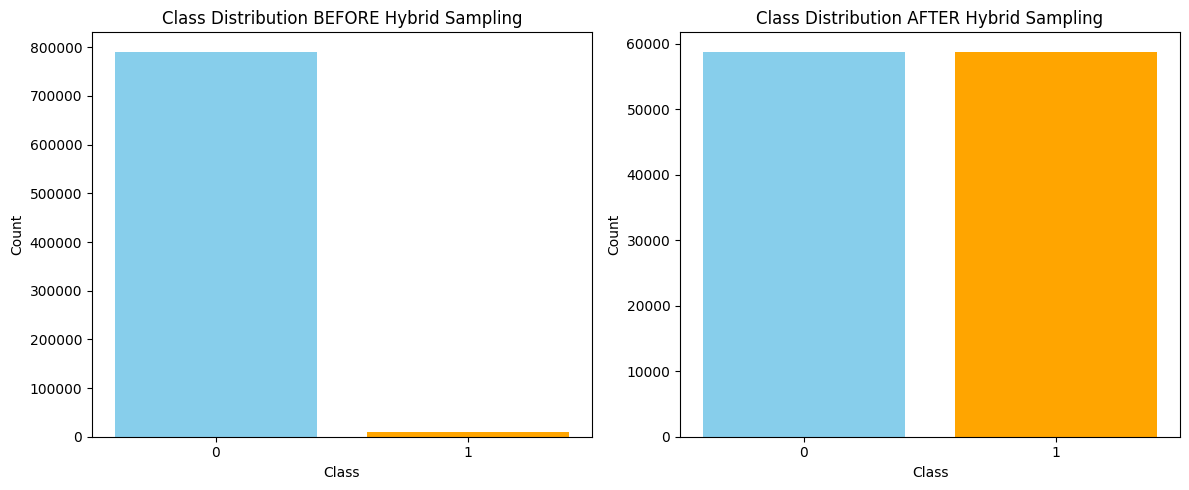

In [162]:
# -------------------------------
# 9. PLOT class distributions
# -------------------------------
plt.figure(figsize=(12, 5))
# Before sampling
plt.subplot(1, 2, 1)
plt.bar(before_counts.index.astype(str), before_counts.values, color=colors)
plt.title("Class Distribution BEFORE Hybrid Sampling")
plt.xlabel("Class")
plt.ylabel("Count")

# After sampling
plt.subplot(1, 2, 2)
plt.bar(after_counts.index.astype(str), after_counts.values, color=colors)
plt.title("Class Distribution AFTER Hybrid Sampling")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

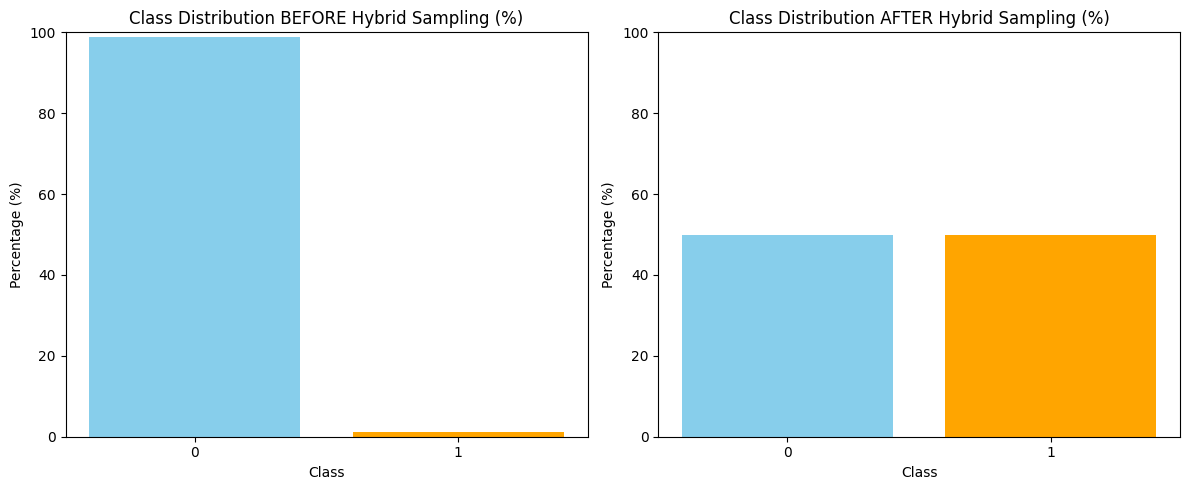

In [163]:

# -------------------------------
# 10. PLOT class distributions (percentages)
# -------------------------------
before_percent = before_counts / before_counts.sum() * 100
after_percent = after_counts / after_counts.sum() * 100

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(before_percent.index.astype(str), before_percent.values, color=colors)
plt.title("Class Distribution BEFORE Hybrid Sampling (%)")
plt.xlabel("Class")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)

plt.subplot(1, 2, 2)
plt.bar(after_percent.index.astype(str), after_percent.values, color=colors)
plt.title("Class Distribution AFTER Hybrid Sampling (%)")
plt.xlabel("Class")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

In [164]:
# Combine features and target into a single DataFrame
df_resampled = X_resampled.copy()
df_resampled["fraud_bool"] = y_resampled.values  # add the target column

# Save to CSV
#df_resampled.to_csv("df_resampled.csv", index=False)

In [165]:
# Missing Value Indicators (batch creation)
# ---------------------------
missing_df_resampled = pd.DataFrame({
    f"{col}_missing": df_resampled[col].isna().astype(int)
    for col in df_resampled.columns
    if df_resampled[col].isna().sum() > 0
})

missing_df_resampled.head()

""


In [166]:
df_resampled.duplicated().sum()


0

In [167]:
# Calculate Q1 and Q3 for numeric columns
Q1 = df_resampled.quantile(0.25)
Q3 = df_resampled.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers: True if value < Q1 - 1.5*IQR or > Q3 + 1.5*IQR
outliers = ((df_resampled < (Q1 - 1.5 * IQR)) | (df_resampled > (Q3 + 1.5 * IQR)))

# Count of outliers per column
outliers.sum()




income                                  0
name_email_similarity                   0
prev_address_months_count           25322
current_address_months_count         3947
customer_age                          306
days_since_request                  17073
intended_balcon_amount              25862
payment_type                           11
zip_count_4w                         6547
velocity_6h                          1191
velocity_24h                          327
velocity_4w                             0
bank_branch_count_8w                18650
date_of_birth_distinct_emails_4w     1909
employment_status                   19539
credit_risk_score                     141
email_is_free                           0
housing_status                         16
phone_home_valid                        0
phone_mobile_valid                  21450
bank_months_count                       0
has_other_cards                     14203
proposed_credit_limit                   0
foreign_request                   

In [168]:
# Copy to avoid modifying original accidentally
df_cleaned = df_resampled.copy()

# Columns to cap
cap_cols = [
    'prev_address_months_count', 'current_address_months_count', 'customer_age',
    'days_since_request', 'intended_balcon_amount', 'zip_count_4w',
    'velocity_6h', 'velocity_24h', 'bank_branch_count_8w',
    'date_of_birth_distinct_emails_4w', 'employment_status',
    'credit_risk_score', 'phone_mobile_valid', 'has_other_cards',
    'foreign_request', 'session_length_in_minutes', 'device_distinct_emails_8w'
]

# Apply capping
for col in cap_cols:
    lower = df_cleaned[col].quantile(0.01)
    upper = df_cleaned[col].quantile(0.99)
    df_cleaned[col] = df_cleaned[col].clip(lower, upper)




In [169]:
skewed_cols = [
    col for col in df_cleaned.columns
    if df_cleaned[col].dtype != 'O'           # numeric
    and df_cleaned[col].nunique() > 10        # continuous
    and (df_cleaned[col] > 0).all()           # strictly positive
]
log_df = pd.DataFrame({
    f"{col}_log": np.log1p(df[col])
    for col in skewed_cols
})


c:\Users\Emma. O.Kyei Mckeow\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Emma. O.Kyei Mckeow\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [170]:
interaction_pairs = [
    ("velocity_6h", "velocity_24h"),
    ("device_fraud_count", "device_distinct_emails_8w"),
    ("prev_address_months_count", "current_address_months_count"),
]

interaction_dict = {}

for f1, f2 in interaction_pairs:
    if f1 in df_cleaned.columns and f2 in df_cleaned.columns:
        interaction_dict[f"{f1}_x_{f2}"]    = df_cleaned[f1] * df_cleaned[f2]
        interaction_dict[f"{f1}_plus_{f2}"] = df_cleaned[f1] + df_cleaned[f2]
        interaction_dict[f"{f1}_ratio_{f2}"] = df_cleaned[f1] / (df_cleaned[f2] + 1)

interaction_df = pd.DataFrame(interaction_dict)
interaction_df.head()

,velocity_6h_x_velocity_24h,velocity_6h_plus_velocity_24h,velocity_6h_ratio_velocity_24h,device_fraud_count_x_device_distinct_emails_8w,device_fraud_count_plus_device_distinct_emails_8w,device_fraud_count_ratio_device_distinct_emails_8w,prev_address_months_count_x_current_address_months_count,prev_address_months_count_plus_current_address_months_count,prev_address_months_count_ratio_current_address_months_count
0,2.430980e+07,10071.558980,1.510334,0,1,0.0,3953,126,0.867647
1,1.541233e+07,8043.987995,1.554885,0,1,0.0,-135,134,-0.007353
2,2.799744e+07,10592.763868,0.915607,0,1,0.0,-362,361,-0.002755
3,1.627715e+07,8099.788091,1.190554,0,1,0.0,300,35,1.250000
4,9.532841e+06,6306.024826,0.662690,0,1,0.0,2548,119,3.137931


In [171]:
df_engineered = pd.concat([df, missing_df_resampled, log_df, interaction_df], axis=1)
df_engineered.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,session_length_in_minutes_log,velocity_6h_x_velocity_24h,velocity_6h_plus_velocity_24h,velocity_6h_ratio_velocity_24h,device_fraud_count_x_device_distinct_emails_8w,device_fraud_count_plus_device_distinct_emails_8w,device_fraud_count_ratio_device_distinct_emails_8w,prev_address_months_count_x_current_address_months_count,prev_address_months_count_plus_current_address_months_count,prev_address_months_count_ratio_current_address_months_count
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,aa,1059,...,2.846353,2.430980e+07,10071.558980,1.510334,0.0,1.0,0.0,3953.0,126.0,0.867647
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,ad,1658,...,1.473356,1.541233e+07,8043.987995,1.554885,0.0,1.0,0.0,-135.0,134.0,-0.007353
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,ab,1095,...,3.166764,2.799744e+07,10592.763868,0.915607,0.0,1.0,0.0,-362.0,361.0,-0.002755
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,ab,3483,...,2.785987,1.627715e+07,8099.788091,1.190554,0.0,1.0,0.0,300.0,35.0,1.250000
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,aa,2339,...,1.556680,9.532841e+06,6306.024826,0.662690,0.0,1.0,0.0,2548.0,119.0,3.137931
